In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [248]:
# funda = pd.read_csv(data_dir + "2018_Financial_Data.csv", index_col = 0)
# for c in funda.columns: print(c)
# growth = ["Gross Profit Growth", "EBIT Growth", "EPS Growth", "Dividends per Share Growth", "Free Cash Flow growth",
#          "Debt Growth", "Asset Growth", "Revenue Growth"]
# val = ["PE ratio", "Price to Sales Ratio", "PB ratio", "EV to Sales", "Enterprise Value over EBITDA", 
#       "EV to Free cash flow", "Earnings Yield", "Free Cash Flow Yield", "Dividend Yield", "Payout Ratio"]
# debt = ["Debt to Equity", "Net Debt to EBITDA", "Current ratio", "Interest Coverage"]
# qual = ["ROIC", "ROE", "Income Quality", "netProfitMargin", "Capex to Revenue"]


# data = funda[["Sector"] + growth + val + debt + qual].dropna()

# def bygrp(grp):
#     g = grp
#     for c in g.columns.difference(["Sector"]):
#         mean = g[c].mean()
#         g[c] = g[c].fillna(mean)
#     return g
# data = data.groupby("Sector").apply(bygrp)
# secs = data[["Sector"]]
# data.drop("Sector", axis=1, inplace=True)
# ranks = data.rank()
# stand = ranks.sub(ranks.mean(), axis=1).div(ranks.std(), axis=1)
# secs.to_csv(data_dir + "secs.csv")
# stand.to_csv(data_dir + "funda.csv")

In [249]:
data_dir = "C:/Users/Phili/Documents/exjobb/data/"
stocks = pd.read_csv(data_dir + "ex_aktier.csv")
df = stocks.set_index("Date")
df.index = pd.to_datetime(df.index)
df = df.loc["1999-12-31":"2020-03-31"]
df = df.set_index([df.index, "Isin"]).unstack()["Close"].pct_change()[1:]
df[df == 0.0] = np.nan
mu = df.mean()
std = df.std()
rates = pd.read_csv(data_dir + "rates_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
cmdty = pd.read_csv(data_dir + "cmdty_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates=True)
index = pd.read_csv(data_dir + "index.csv", index_col =0, parse_dates = True)
Y = rates.join(cmdty).join(index)
Y = Y.reindex(df.index).fillna(method="pad")["OMX"]
Y.shape, df.shape

((5208,), (5208, 2975))

In [251]:
stocks

,Isin,Date,Close
0,DK0000008960,1973-01-01 00:00:00.000,94.416266
1,DK0010001601,1973-01-01 00:00:00.000,119.696768
2,DK0010004035,1973-01-01 00:00:00.000,35.034607
3,DK0010006162,1973-01-01 00:00:00.000,153.405604
4,DK0010009505,1973-01-01 00:00:00.000,167.991040
...,...,...,...
6550780,SE0013720018,2020-04-02 00:00:00.000,63.000000
6550781,SE0013747870,2020-04-02 00:00:00.000,25.550004
6550782,SE0013748001,2020-04-02 00:00:00.000,4.500000
6550783,SE0013914249,2020-04-02 00:00:00.000,13.180001


(2595, 27)

In [61]:
T = 252
n_x = 1


X = []
y = []
t_list = []
t_dict = {}
steps = len(df) // T
windows = 100

def make_one_hot(labels, C = 5):
    y = torch.eye(C) 
    return y[labels.long()].squeeze(1)

def calc_y(y):
    ret = y.iloc[-1]/y.iloc[0] - 1
    std = y.pct_change().std()*np.sqrt(252)
    #print(ret, std)
    if ret > 0.12:
        return 0
    elif ret <= 0.12 and ret > 0.03:
        return 1
    elif ret <= 0.03 and ret > -0.03:
        return 2
    elif ret <= -0.03 and ret > -0.12:
        return 3
    elif ret <= -0.12:
        return 4
#     if ret > 0:
#         return 0
#     else:
#         return 1

for t in range(steps-1):
    df_t = df.iloc[t*T:(t+1)*T].dropna(axis=1, thresh = 55).fillna(0.0).clip(-0.5,0.5)
    y_t = Y.iloc[t*T:(t+1)*T]
    y_t = calc_y(y_t)
    #y_t = y_t.iloc[-1] / y_t.iloc[0] - 1
    #calc_y(y_t)
    #df_t = df_t.sub(df_t.mean(), axis=1).div(df_t.std(), axis=1).dropna(axis=1)
    df_t = (1.0 + df_t).cumprod()
    t_dict[t] = (df_t.index[0], df_t.index[-1])
    if df_t.shape[1] < n_x:
        continue
#     for _ in range(windows):
#         t_list.append([t])
#         i = np.random.choice(np.arange(df_t.shape[1]), n_x, replace=False)
#         df_t_i = df_t.iloc[:,i]
#         #df_t_i = df_t_i.sub(df_t_i.mean(), axis=1).div(df_t_i.std(), axis=1)
#         X.append(df_t_i.values.reshape(-1,1).squeeze())
#         #y.append(y_t.values.reshape(-1,1).squeeze())
#         y.append([y_t])
    for _ in range(df_t.shape[1]):
        t_list.append([t])
        y.append([y_t])
        X.append(df_t.iloc[:,_].values.reshape(-1,1).squeeze())
    
    

X = np.array(X)
y = np.array(y)
t_arr = np.array(t_list)
y.shape, X.shape, t_arr.shape

((19425, 1), (19425, 252), (19425, 1))

In [62]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)
t = pd.DataFrame(t_arr, columns= ["t"])
t["date"] = [t_dict[i][0] for i in t.t]
t

,t,date
0,0,2000-01-04
1,0,2000-01-04
2,0,2000-01-04
3,0,2000-01-04
4,0,2000-01-04
...,...,...
19420,18,2017-08-08
19421,18,2017-08-08
19422,18,2017-08-08
19423,18,2017-08-08


In [63]:
X.min().min()

0.00010045242572063329

In [64]:
X.to_csv(data_dir + "stocks_curves.csv", index=False)
y.to_csv(data_dir + "y.csv", index=False)
t.to_csv(data_dir + "t.csv", index=False)

In [65]:
X.shape

(19425, 252)

In [244]:
df = pd.read_csv(data_dir + "hist_ex.csv")
X = df.pivot(index="Date", columns = "Isin", values = "Close")

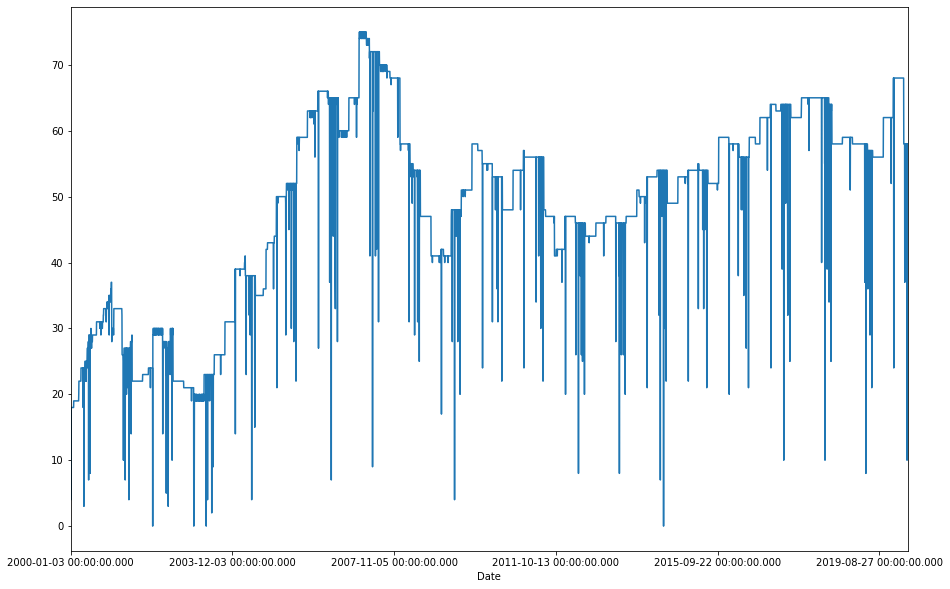

In [247]:
X.count(axis=1).plot(legend=False, figsize=(15,10))